DISTILBERT SENTIMENT ANALYSE

In [ ]:
#!pip install --upgrade pip setuptools wheel
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
#!pip install transformers pandas matplotlib

In [2]:
#Load resources
import pandas as pd
from transformers import pipeline

In [3]:
#load data
data = pd.read_csv('/content/comb_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67992 entries, 0 to 67991
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              67992 non-null  object 
 1   name            61232 non-null  object 
 2   brand           67992 non-null  object 
 3   reviews.date    67953 non-null  object 
 4   reviews.rating  67959 non-null  float64
 5   reviews.text    67991 non-null  object 
 6   reviews.title   67973 non-null  object 
dtypes: float64(1), object(6)
memory usage: 3.6+ MB


In [4]:
## Model selection

sentiment_pipe = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)


Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

In [5]:
# Redefine Text column

texts = data["reviews.text"].fillna("").astype(str).tolist()


In [6]:
# start small first (fast)
results = sentiment_pipe(texts[:200], batch_size=32, truncation=True)

data.loc[:len(results)-1, "bert_sentiment"] = [r["label"] for r in results]
data.loc[:len(results)-1, "bert_score"] = [r["score"] for r in results]

data[["reviews.text", "bert_sentiment", "bert_score"]].head(10)

,reviews.text,bert_sentiment,bert_score
0,This product so far has not disappointed. My c...,POSITIVE,0.999668
1,great for beginner or experienced person. Boug...,POSITIVE,0.999852
2,Inexpensive tablet for him to use and learn on...,POSITIVE,0.997491
3,I've had my Fire HD 8 two weeks now and I love...,POSITIVE,0.999776
4,I bought this for my grand daughter when she c...,POSITIVE,0.995453
5,This amazon fire 8 inch tablet is the perfect ...,POSITIVE,0.997538
6,"Great for e-reading on the go, nice and light ...",POSITIVE,0.999854
7,"I gave this as a Christmas gift to my inlaws, ...",POSITIVE,0.999878
8,Great as a device to read books. I like that i...,POSITIVE,0.999606
9,I love ordering books and reading them with th...,POSITIVE,0.999474


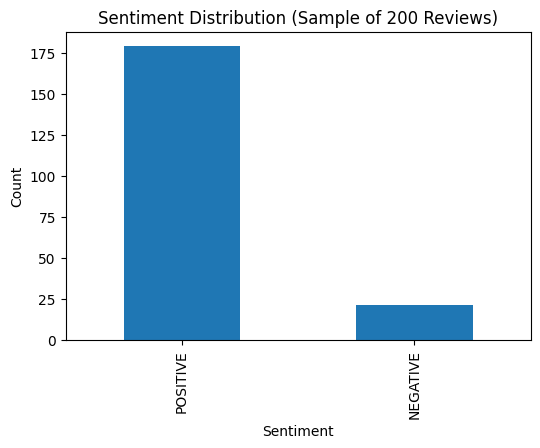

In [7]:
# Plot the sentiment distribution (for the sample)
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
data["bert_sentiment"][:200].value_counts().plot(kind="bar")
plt.title("Sentiment Distribution (Sample of 200 Reviews)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [8]:
## Create sentiment labels from ratings:

def rating_to_sentiment(rating):
    if rating >= 4:
        return 1   # positive
    elif rating == 3:
        return 0   # neutral (optional)
    else:
        return -1  # negative

data["sentiment"] = data["reviews.rating"].apply(rating_to_sentiment)



In [9]:
## Keeping only needed columnn:

data = data[["reviews.text", "sentiment"]].dropna()
data = data.rename(columns={"reviews.text": "text"})

In [10]:
## Splitting data into train and test sets:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data["sentiment"]) #keeping class balance

#Check sizes:
print(f"Train set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")


Train set size: 54392
Test set size: 13599


In [11]:
## Converting to Hugging Face Datasets format:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_data.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_data.reset_index(drop=True))

In [12]:
## SAnity check:
print(train_dataset[0])

{'text': "Great deal- don't waste any more money buying batteries at the store! You can't beat the price and they work and lask as well as brand name batterys. It it amazing how much cheaper these are- and you get twice as many. I got these in AA, AAA, C and D. The main reason I even bought them was when I was looking for flashlight batteries- size D for my trusty maglight (yes they are heavy but I love them for it, they are perfect for a car and the weight keeps it steady if you have to put it down) and size C for a different flashlight. Of course I needed an odd number and couldn't believe how expensive they were in the store. I checked Amazon- had no clue amazon had their own batteries and noticed that in all of the sizes- the price was less then the smallest pack of that size in the store and had twice as many batteries. Did I need this many AAA batteries at the time- nope but let me tell you I'm so glad I got extra- less than a week after buying them I had already nearly used ever

In [14]:
## Load DistilBERT for training

from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [24]:
## Tokenizing the data with DistilBERT tokenizer:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
from transformers import DataCollatorWithPadding ## Data collator (to save RAM vs padding)

max_len=192

def tokenize_function(data):
    return tokenizer(data["text"],
        max_length=max_len,
        truncation=True)

train_tok = train_dataset.map(tokenize_function, batched=True)
test_tok = test_dataset.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/54392 [00:00<?, ? examples/s]

Map:   0%|          | 0/13599 [00:00<?, ? examples/s]

In [15]:
#Redifinig labels:
data["labels"] = data["sentiment"].map({-1: 0, 0: 1, 1: 2})
data = data[["text", "labels"]]

In [22]:
## Last adjustments before training:
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import DistilBertTokenizer

# Use the 'data' DataFrame which now contains the 'labels' column
train_data_df, test_data_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data["labels"])

# Convert to Hugging Face Datasets format
train_dataset = Dataset.from_pandas(train_data_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_data_df.reset_index(drop=True))

# Initialize tokenizer if not already done, though it's done in 1f32d8fd
#tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

#def tokenize_function(data):
    #return tokenizer(data["text"],
        #padding="max_length",
        #truncation=True)

#train_tok = train_dataset.map(tokenize_function, batched=True)
#test_tok = test_dataset.map(tokenize_function, batched=True)

In [25]:
## Train wth trainer
import numpy as np
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score
from transformers import EarlyStoppingCallback

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro")
    }

#defining arguments
training_args = TrainingArguments(
    output_dir="./distilbert_reviews",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    fp16=True,
    logging_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    dataloader_num_workers=4,
    dataloader_pin_memory=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=test_tok,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

#training
trainer.train()

#evaluate
trainer.evaluate()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.149770,0.139792,0.956541,0.740856
2,0.102095,0.149723,0.961468,0.773529
3,0.061808,0.175815,0.958379,0.788068
4,0.039488,0.194933,0.961909,0.793057
5,0.033029,0.207457,0.962865,0.800912


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


{'eval_loss': 0.20745667815208435,
 'eval_accuracy': 0.9628649165379808,
 'eval_f1': 0.8009122577459187,
 'eval_runtime': 15.0473,
 'eval_samples_per_second': 903.748,
 'eval_steps_per_second': 14.155,
 'epoch': 5.0}

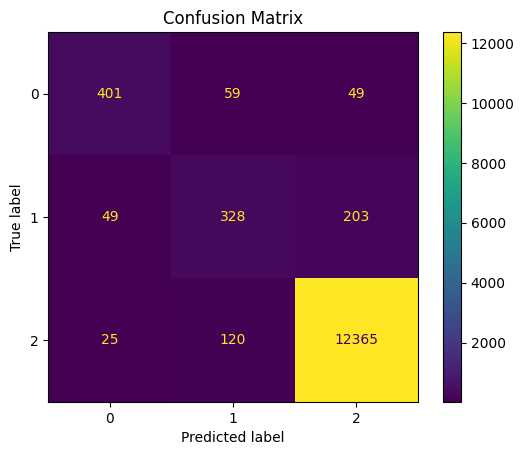

In [26]:
## confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

predictions = trainer.predict(test_tok)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = ["Negative", "Neutral", "Positive"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.title("Confusion Matrix")
plt.show()


##FINE TUNING


In [34]:
#Loading data
data = pd.read_csv("/content/comb_data.csv")

# Keeping only the columns we need and drop missing values
data = data[["reviews.text", "reviews.rating"]].dropna()
data = data.rename(columns={"reviews.text": "text"})

# creating labels: 0=negative, 1=neutral, 2=positive
def rating_to_label(r):
    if r >= 4:
        return 2
    elif r == 3:
        return 1
    else:
        return 0

data["labels"] = data["reviews.rating"].apply(rating_to_label).astype(int)

#Splitting into train/val/test
train_df, temp_df = train_test_split(
    data[["text", "labels"]],
    test_size=0.2,
    random_state=42,
    stratify=data["labels"],  # keeps label proportions similar in each split
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df["labels"],
)
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 54366 | Val: 6796 | Test: 6796


In [35]:
# Converting pandas to Huggingg Face Dataset:
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True))

In [36]:
# DistilBERT tokenizer + tokenization (FAST)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
MAX_LEN = 192
def tokenize(batch):
  return tokenizer(batch["text"], truncation=True, max_length=MAX_LEN)

# Tokenize each split.
train_tok = train_ds.map(tokenize, batched=True)
val_tok   = val_ds.map(tokenize, batched=True)
test_tok  = test_ds.map(tokenize, batched=True)

# Dynamic padding pads each batch to the longest sequence in that batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/54366 [00:00<?, ? examples/s]

Map:   0%|          | 0/6796 [00:00<?, ? examples/s]

Map:   0%|          | 0/6796 [00:00<?, ? examples/s]

In [37]:
# Loading pretrained DistilBERT with a 3-class classification head
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [38]:
# Metrics for evaluation
def compute_metrics(eval_pred):
    # eval_pred = (logits, labels)
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
    }

In [39]:
# Training configuration
training_args = TrainingArguments(
    output_dir="./distilbert_reviews",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    fp16=True, # Mixed precision = big speedup on GPU
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    logging_steps=200,
    dataloader_num_workers=4, # Speed up data loading
    dataloader_pin_memory=True,
)

In [44]:
# Trainer + early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
)

In [45]:
# Fine-tune the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.160038,0.181185,0.949971,0.653445
2,0.114305,0.168045,0.951736,0.704309
3,0.076577,0.174754,0.955562,0.772401
4,0.050833,0.183125,0.958505,0.778810
5,0.033054,0.198896,0.960124,0.783524


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=8495, training_loss=0.09597831836091975, metrics={'train_runtime': 955.9949, 'train_samples_per_second': 284.343, 'train_steps_per_second': 8.886, 'total_flos': 9824902876967148.0, 'train_loss': 0.09597831836091975, 'epoch': 5.0})

In [46]:
# Final test evaluation
test_metrics = trainer.evaluate(test_tok)
print(test_metrics)

{'eval_loss': 0.20260107517242432, 'eval_accuracy': 0.9601236021188935, 'eval_f1_macro': 0.7864672664719118, 'eval_runtime': 7.5191, 'eval_samples_per_second': 903.828, 'eval_steps_per_second': 14.23, 'epoch': 5.0}


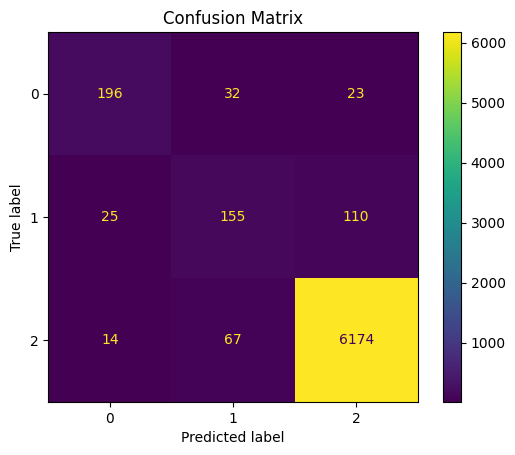

In [47]:
## confusion matrix
predictions = trainer.predict(test_tok)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = ["Negative", "Neutral", "Positive"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Save final model + tokenizer for later inference
trainer.save_model("./distilbert_reviews_final")
tokenizer.save_pretrained("./distilbert_reviews_final")